# DL0ABT IARU Region 1 FD SSB

Es handelt sich hier um eine Auswertung der QSOs der Amateurfunk-Klubstation
[DL0ABT](https://www.darc.de/der-club/distrikte/d/ortsverbaende/25/klubstation-dl0abt/) während
der Teilnahme am IARU Region 1 SSB [Fieldday](https://www.darc.de/der-club/referate/conteste/iaru-region-1-fieldday/fd/) am 7-8.9.2019: Op, Bänder, QSO-Raten.

Wir haben in der Klasse "fixed" teilgenommen mit Stromanschluss,
bis zum Abend des 7.9. mit 100 W, anschließend mit einer Endstufe mit Sendeleistung im Bereich 200-500 W PEP,
beides an einer zwischen zwei Bäumen in ca 10..15 m Höhe aufgespannten G5RV-Dipolantenne.

QTH war JO62nf, genauer 52,2419° N und 13,1544° Ost in
[Glau](https://www.openstreetmap.org/?mlat=52.2419&mlon=13.1544#map=10/52.2419/13.1544)
südlich von Berlin, im Gebiet DLFF-0095. Wir sind dort mit unserer Clubstation
seit Jahren immer wieder gerne Gäste der
[Johannischen Kirche](https://www.johannische-kirche.org/de/06_gemeinden/27_urgemeinde/index.php).

Das hier veröffentliche Material enthält personenbezogene Daten von zwei teilnehmenden Funkamateuren.
Beide haben der Veröffentlichung zugestimmt (Danke, Jan!).

## Grenzen der Auswertung

Ich habe es aus Zeitnot leider (noch) nicht geschafft, irgendwelche Auswertungen über Multiplikatoren zu machen.

## Benutzte Software

Es handelt sich um ein [Jupyter](https://jupyter.org/) Notebook (entwickelt und gerendert mit jupyter lab 1.1.3). Außer Jupyter und [Python](https://docs.python.org/3/) habe ich [Matplotlib](https://matplotlib.org/index.html) und [NumPy](https://numpy.org/) benutzt.
Die "üblichen Verdächtigen" halt. Normalerweise würde man noch 
[Pandas](https://pandas.pydata.org/) dazunehmen, das habe ich hier (mehr aus Versehen
als geplant) nicht getan.

Wer nur die PDF-Datei hat und den Code nicht abtippen will: Der Sourcecode ist
auch komplett [verfügbar](https://github.com/aknrdureegaesr/iaru-reg1-fd-dl0abt-2019).

## Open Source

Copyright © 2019 Andreas Krüger [DJ3EI](dj3ei@famsik.de)

Dieses Notebook ist freie Software. Sie können es unter den Bedingungen der GNU General Public License, wie von der Free Software Foundation veröffentlicht, weitergeben und/oder modifizieren, entweder gemäß Version 3 der Lizenz oder (wenn Sie das wünschen) jeder späteren Version.

Die Veröffentlichung dieses Notebooks erfolgt in der Hoffnung, daß es Ihnen von Nutzen sein wird, aber **ohne irgendeine Garnatie**, sogar ohne die implizite Garantie der **Marktreife** oder
der **Verwendbarkeit für einen bestimmten Zweck**. Details finden Sie in der GNU General Public License.

Sie erhalten ein Exemplar der GNU General Public License von <http://www.gnu.org/licenses/>.

## Software importieren

Ich habe im Laufe der Entwicklung bemerkt, dass dieses Notebook unstabil wird,
wenn ich die Imports erst dann mache, wenn ich sie erstmals brauche. Bei
Operationen "Kernel neu starten und alles neu rendern" fehlten Graphiken.
Ich habe das nicht weiter untersucht. 
Durch Sammlung aller Imports an den Anfang des Notebooks verschwand das Problem.

In [1]:
import re
from datetime import timedelta, datetime, timezone
import functools
import collections

import matplotlib as mpl
import matplotlib.pyplot as plt # https://matplotlib.org/contents.html
from matplotlib.dates import DateFormatter

import numpy as np



## Adif log einlesen

Die folgenden Zeilen sind vielleicht die Kronjuwelen dieses Notebooks:
Ein simpler, aber funktionstüchtiger ADIF-Parser in (wenn man die Kommentare
weglässt) 40 Zeilen Python-Code. Er benötigt nur `import re`.

In [2]:
# This is an ADIF parser in Python.

# It knows nothing about ADIF data types or enumerations,
# everything is a string, so it is fairly simple.

# But it does correcly handle things like:
# <notes:66>In this QSO, we discussed ADIF and in particular the <eor> marker.
# So, in that sense, this parser is somewhat sophisticated.

# Main result of parsing: List of QSOs.
# Each QSO is one Python dict.
# Keys in that dict are ADIF field names in lower case,
# value for a key is whatever was found in the ADIF, as a string.
# Order of QSOs in the list is same as in ADIF file.
qsos = []

# The ADIF file header keys and values, if any. (Not needed by this notebook.)
adif_headers = {}

header_field_re = re.compile(r'<((eoh)|(\w+)\:(\d+)(\:[^>]+)?)>', re.IGNORECASE)
field_re = re.compile(r'<((eor)|(\w+)\:(\d+)(\:[^>]+)?)>', re.IGNORECASE)

with open("DL0ABT-ssb-fd-2019-09.adif.adi") as adif_file:
    adif = adif_file.read()
    cursor = 0
    if adif[0] != '<':
        # Has ADIF header.
        eoh_found = False
        while(not eoh_found):
            header_field_mo = header_field_re.search(adif, cursor)
            if header_field_mo.group(2):
                eoh_found = True
                cursor = header_field_mo.end(0)
            else:
                field = header_field_mo.group(3).lower()
                value_start = header_field_mo.end(0)
                value_end = value_start + int(header_field_mo.group(4))
                value = adif[value_start:value_end]
                adif_headers[field] = value
                cursor = value_end
        
    qso = {}
    field_mo = field_re.search(adif, cursor)
    while(field_mo):
        if field_mo.group(2):
            # <eor> found:
            qsos.append(qso)
            qso = {}
            cursor = field_mo.end(0)
        else:
            # Field found:
            field = field_mo.group(3).lower()
            value_start = field_mo.end(0)
            value_end = value_start + int(field_mo.group(4))
            value = adif[value_start:value_end]
            qso[field] = value
            cursor = value_end
        field_mo = field_re.search(adif, cursor)

Hier noch einige einheitliche Formatierungen für alle Diagramme:

In [3]:
mpl.rcParams['font.size'] = 16
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'large'

## Aktivitäten

Unser Fieldday ist ziemlich entspannt. Oft ist die Station verwaist, man unterhält sich und allen geht es gut. Mal sehen, wie viel wir überhaupt gefunkt haben. Bei der Gelegenheit auch, wie viel davon wir selbst CQ gerufen haben und wie viel "Search &amp; Pounce" dabei war.

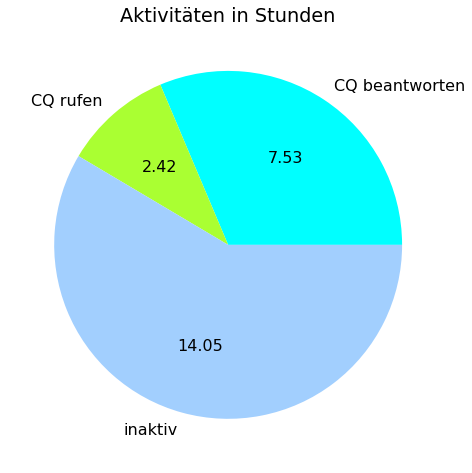

In [4]:
# Heuristics:
# If frequency does not change between one QSO and the next,
# we have been calling CQ for both.

# Thanks to CAT, we do have precise freq data in our log.

# Helper: Translate boolean to a string that says who has been calling CQ:
def b2who(b):
    return 'DL0ABT' if b else 'QSO-Partner'

l = len(qsos)

qsos[0]['cq'] = b2who(qsos[0]['freq'] == qsos[1]['freq'])
qsos[l-1]['cq'] = b2who(qsos[l-1]['freq'] == qsos[l-2]['freq'])

for i in range(1, l-1):
    freq = qsos[i]['freq']
    qsos[i]['cq'] = b2who((qsos[i-1]['freq'] == freq) or (qsos[i+1]['freq'] == freq))

# Generate a Python timestamp from a QSO's qso_date and time_on.
def timeon(qso):
    date = qso['qso_date']
    y = int(date[0:4])
    mo = int(date[4:6])
    d = int(date[6:8])
    time = qso['time_on']
    h = int(time[0:2])
    mi = int(time[2:4])
    s = int(time[4:6])
    return datetime(y, mo, d, h, mi, s, tzinfo = timezone.utc)

# Values to be adjusted later:
activity2duration = {'CQ rufen': 0.0, 'CQ beantworten': 0.0, 'inaktiv': 0.0}

# Heuristic: No QSO for 20 minutes means we took a break.
seconds_break_threshold = 20 * 60

conteststart = datetime(2019, 9, 7, 13, 0, 0, tzinfo = timezone.utc)
previous_time = conteststart
for i in range(1, l):
    qso = qsos[i]
    time_of_qso = timeon(qso)
    seconds_since_previous = (time_of_qso - previous_time).total_seconds()
    if seconds_break_threshold <= seconds_since_previous:
        activity2duration['inaktiv'] = activity2duration['inaktiv'] + seconds_since_previous
    elif qso['cq'] == 'DL0ABT':
        activity2duration['CQ rufen'] = activity2duration['CQ rufen'] + seconds_since_previous
    else:
        activity2duration['CQ beantworten'] = activity2duration['CQ beantworten'] + seconds_since_previous
    previous_time = time_of_qso    

def plotit():
    sels = sorted(activity2duration.keys())
    nums = [activity2duration[sel] for sel in sels]
    fig, ax = plt.subplots(figsize = [8,8])

    ax.pie(nums, labels = sels, autopct = lambda x: "{:4.2f}".format(x * 24.0 / 100),
           colors = ['xkcd:cyan', 'xkcd:lime', 'xkcd:baby blue',
                     'xkcd:light pink', 'xkcd:yellow', 'xkcd:light orange' ])
    ax.set_title("Aktivitäten in Stunden")
    plt.show(block = True)
    
plotit()



## QSOs pro Operator

Es war so viel Inaktivität dabei, weil nur zwei Ops die Station bedient haben.
Es waren einige andere da, die haben einfach die Urlaubsatmosphäre
am Contest-QTH genossen.

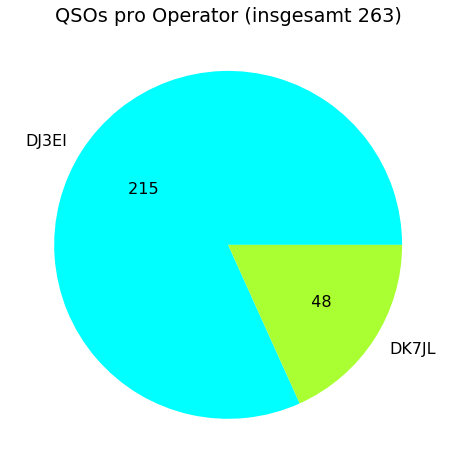

In [5]:

def filter_by_op(qso):
    return 'DK7JL' if qso['operator'] == 'DL0ABT' else qso['operator']

def plot_by_selection(qsos, select, title, sort_sel=None):
    
    def inc_sel2num(sel2num, qso):
        sel = select(qso)
        sel2num[sel] = sel2num[sel] + 1
        return sel2num

    sel2num = functools.reduce(inc_sel2num, qsos, collections.Counter())
    sels = sorted(sel2num.keys(), key=sort_sel)
    nums = [sel2num[sel] for sel in sels]
    fig, ax = plt.subplots(figsize = [8,8])

    ax.pie(nums, labels = sels, autopct = lambda x: "{:4.0f}".format(x * len(qsos) / 100),
           colors = ['xkcd:cyan', 'xkcd:lime', 'xkcd:baby blue',
                     'xkcd:light pink', 'xkcd:yellow', 'xkcd:light orange' ])
    ax.set_title(title)
    plt.show(block = True)
    return sel2num

title = 'QSOs pro Operator (insgesamt {})'.format(l)
plot_by_selection(qsos, filter_by_op, title)
pass

Persönliche Bemerkung von mir als dem Haupt-Op: Es war auch mal ganz schön, so eine große
Station über lange Zeit "für mich" zu haben. Aber noch mehr hätte mich gefreut,
wenn ich nicht über weite Strecken alleine gefunkt hätte, sondern mehr Op über längere Zeit
mitgemacht hätten.

## QSOs pro Band

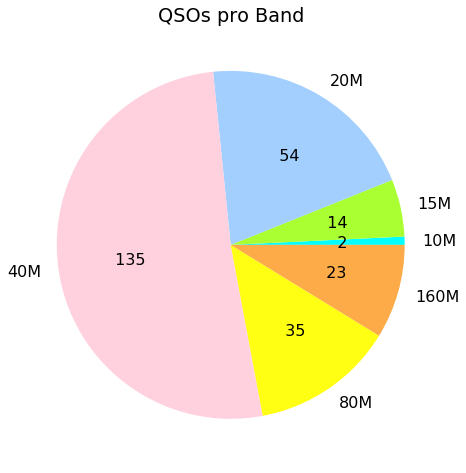

In [6]:
def sort_key_band(band):
    return "0{}".format(band) if len(band) == 3 else band
plot_by_selection(qsos, lambda qso: qso['band'], 'QSOs pro Band', sort_key_band)
pass

## Erreichte Kontinente

Das derzeitige Sonnenfleckenminimum hat kräftig zugeschlagen, wir sind nur sehr wenig über Europa hinausgekommen.

Daher sind die Zahlen in der Graphik schlecht zu erkennen. Dieselben Daten folgen daher als Texttabelle, wie Python sie ausgibt.

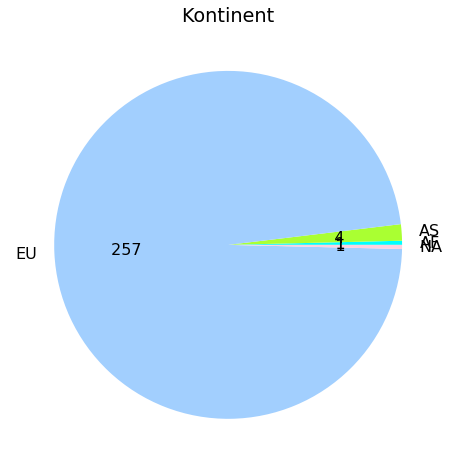

Counter({'AF': 1, 'AS': 4, 'EU': 257, 'NA': 1})

In [7]:
plot_by_selection(qsos, lambda qso: qso['app_n1mm_continent'], 'Kontinent')

## Suchen vs. CQ rufen

Ich hatte subjektiv den Eindruck, dass beim CQ-Rufen viel mehr passiert als beim "Search &amp; Pounce". Mal sehen...

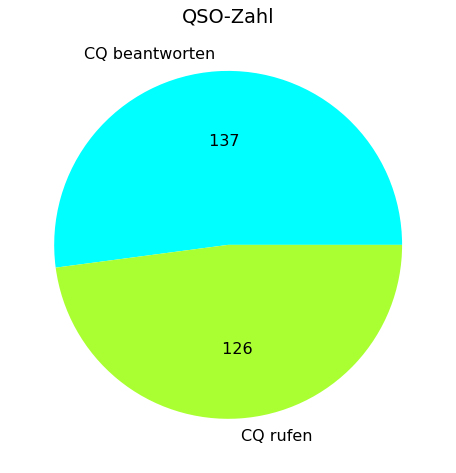

In [8]:
qsonum_by_activity = None
if 2 < l:
    
    def qso2label(qso):
        if qso['cq'] == 'DL0ABT':
            return 'CQ rufen'
        else:
            return 'CQ beantworten'

    qsonum_by_activity = plot_by_selection(qsos, qso2label, 'QSO-Zahl')

### QSOs pro Zeitaufwand

Wir haben deutlich kürzere Zeit CQ gerufen, verglichen mit der Zeit des "Kurbelns"
über die Bänder. Die QSO-Zeiten sind trotzdem nicht sehr unterschiedlich.
Da muss die QSO-Rate von "Seach &amp; Pounce" deutlich geringer sein!

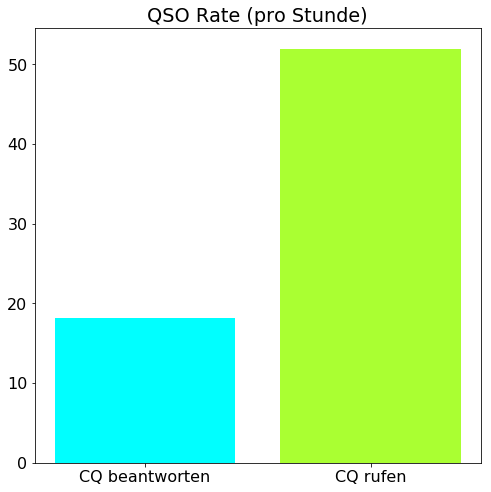

[18.201948627103633, 51.98258079303232]

In [9]:
activities = sorted(qsonum_by_activity.keys())

qsos_per_activityhour = [qsonum_by_activity[a] / activity2duration[a] * 3600 for a in activities]

barx = np.arange(len(activities))

fig, axs = plt.subplots(figsize = [8, 8])
plt.bar(barx, qsos_per_activityhour, color = ['xkcd:cyan', 'xkcd:lime'])
plt.title("QSO Rate (pro Stunde)")
plt.xticks(barx, activities)
plt.show(block = True)
qsos_per_activityhour

## QSO-Rate

Nun möchte ich eine gleitende momentane QSO-Rate über der Zeit berechnen.

Die Details, wie ich das berechne: Ein einzelnes QSO erzeugt ein "Signal" bei der QSO-Rate,
das einem umgekehrten V gleicht. Ab einer Viertelstunde vor dem QSO-Zeitpunkt
fängt die QSO-Rate an, linear zu steigen. Zum Zeitpunkt des QSOs erreicht sie den Wert 4.
Dann sinkt sie wieder linear ab, genau eine Viertelstunde nach dem QSO ist sie wieder bei Null
angekommen.

Diese einzelnen Signale aller QSOs werden aufaddiert. Das ist die unten dargestellte
QSO-Raten-Kurve.

### Warum gerade der Wert 4?

Wer genau alle Viertelstunde ein QSO macht, macht 4 QSOs pro Stunde. Wenn man genau jede 15 Minuten ein QSO führt, bleibt das Signal "QSO-Rate" konstant bei 4 stehen.
Denn die absteigende Flanke vom letzten QSO und die steigende vom kommenden
addieren sich zu einer konstanten Linie der Höhe 4.

Allgemeineres Argument: Die Fläche unter der QSO-Raten-Linie (mathematisch: das Integral der
QSO-Rate über der Zeit) entspricht genau der Anzahl der QSOs.

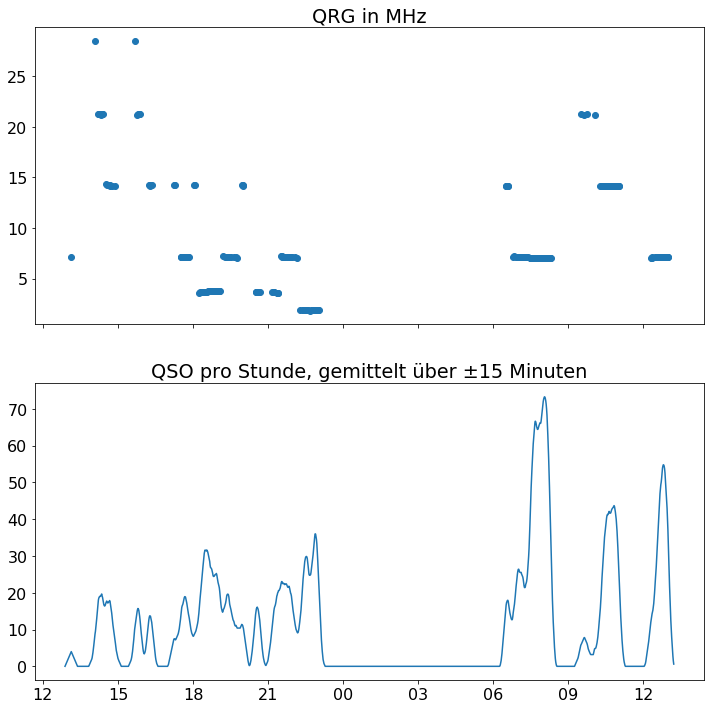

In [10]:

qsotimes = [timeon(qso) for qso in qsos]

# Integrating over simple inverted - V function
# spanning +/- 15 minutes.
d = timedelta(minutes=15)
def qsos_per_hour(qsotimes, t):
    start = t - d
    end = t + d
    def nearness_to_t(time):
        if time <= start:
            return 0.0
        elif end <= time:
            return 0.0
        else:
            return (1.0 - (abs(t-time) / d)) * 4.0
    return functools.reduce(lambda x, t_qso: x + nearness_to_t(t_qso), qsotimes, 0.0)

step = timedelta(minutes=1)
overall_start = qsotimes[0] - d
overall_end = qsotimes[len(qsotimes) - 1] + d
ts = [overall_start + i * step for i in range(0, int((overall_end - overall_start)/step))]
# This is incredibly inefficient:
rates = [qsos_per_hour(qsotimes, t) for t in ts]

# As a test, a crude integration:
# print("total: {}".format(functools.reduce(lambda x, r: x + r, rates, 0.0)/60.0))

fig, axs = plt.subplots(nrows = 2, figsize = [12,12], sharex = 'col')
ax = axs[1]
ax.set_title("QSO pro Stunde, gemittelt über ±15 Minuten")
ax.plot_date(ts, rates, '-', xdate = True, ydate = False)
axs[0].set_title("QRG in MHz")
axs[0].plot_date(qsotimes, [float(qso['freq']) for qso in qsos], 'o', xdate = True, ydate = False)
ax.xaxis.set_major_formatter(DateFormatter('%H'))
plt.show(block = True)
pass
# Maximale QSO-Rate: 
# functools.reduce(lambda max, v: v if max < v else max, rates)

## Tatsächliche QSO-Zahlen pro Stunde

Den Maximalwert von 73,3 QSO/Stunde haben wir natürlich nur für kurze Zeit erreicht, sozusagen im Sprint. Als Realitätscheck hier die tatsächlichen QSO-Zahlen pro (voller) Stunde:

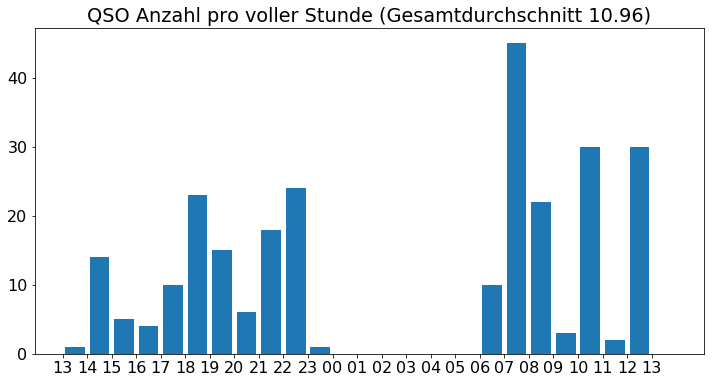

In [11]:
one_hour = timedelta(minutes=60)
test_start = datetime(2019, 9, 7, 13, 0, 0, tzinfo = timezone.utc)
ind = [i for i in range(0, 25)]
hours = [test_start + one_hour * i for i in ind]
def qsos_that_hour(hour):
    def inc_if_in_hour(count, qsotime):
        if hour <= qsotime and qsotime < hour + one_hour:
            return count + 1
        else:
            return count
    return functools.reduce(inc_if_in_hour, qsotimes, 0)
qsos_per_hour = [qsos_that_hour(hour) for hour in hours]
fig, axs = plt.subplots(figsize = [12, 6])
plt.bar([i + 0.5 for i in ind], qsos_per_hour)
plt.title("QSO Anzahl pro voller Stunde (Gesamtdurchschnitt {:5.2f})".format(l / 24.0))
plt.xticks(ind, [h.strftime('%H') for h in hours])
plt.show()
pass

## Demnächst vielleicht: Weiter mit Multis!

Leider stehen im vorhandenen Log die DXCC-Gebiete nicht zur Verfügung.
Die kann man sich von der ARRL besorgen.

Wo, steht auf der Seite [http://www.arrl.org/country-lists-prefixes](http://www.arrl.org/country-lists-prefixes). Zur Zeit von [http://www.arrl.org/files/file/DXCC/2019_Current_Deleted(3).txt](http://www.arrl.org/files/file/DXCC/2019_Current_Deleted(3).txt).

Es gibt da allerdings ein kleines Problem:
Die DXCC-Liste ist nicht einfach nur ein Service der ARRL für die
Amateurfunkgemeinschaft, sondern sie kostet. Als Papier $5.95 plus Versand.
Man darf sie sich aber auch so herunterladen,
*wenn das Herunterladen für persönliche Zwecke geschieht.*

Ist eine Veröffentlichung geplant,
wie in diesem Fall, steht man zunächst einsam im rechtsfreien Raum.

Immerhin: Ich persönlich habe nachgefragt und problemlos die Erlaubnis bekommen,
eine Software zu entwickeln und zu veröffentlichen,
die die DXCC-Liste herunterlädt und verwurstet, sowie auch Ergebnisse zu Veröffentlichen,
die diese Software mit Hilfe der DXCC-Liste erstellt.


